In [1]:
import numpy as np
from csv_utils import load_model_data
import matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "text.usetex": False, # Remove this line if your code doesn't run/ take too long
    "font.family": 'Times New Roman',
    "figure.dpi": 100,
    "font.size": 14
})
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
csv_file = 'data.csv'
full_data = load_model_data(csv_file,load_gauge_fidelity=True)

In [3]:
import numpy as np

# Convert to numpy
F_naive = np.array(full_data['model_average_fidelity'])
F = np.array(full_data['model_average_fidelity_gauge'])
P = np.array(full_data['P_vector'], dtype=object)

# ---- 1. FILTER FIRST ----
mask = F > 0.7

F_naive = F_naive[mask]
F = F[mask]
P = P[mask]

# ---- 2. SHUFFLE ----
n = len(F)
perm = np.random.permutation(n)

F_naive = F_naive[perm]
F = F[perm]
P = P[perm]

# ---- 3. SPLIT ----
split = int(0.8 * n)

F_naive_train, F_naive_test = F_naive[:split], F_naive[split:]
F_train, F_test = F[:split], F[split:]
P_train, P_test = P[:split], P[split:]

# ---- 4. (Optional) back to lists ----
F_naive_train = F_naive_train.tolist()
F_naive_test  = F_naive_test.tolist()
F_train = F_train.tolist()
F_test  = F_test.tolist()
P_train = P_train.tolist()
P_test  = P_test.tolist()


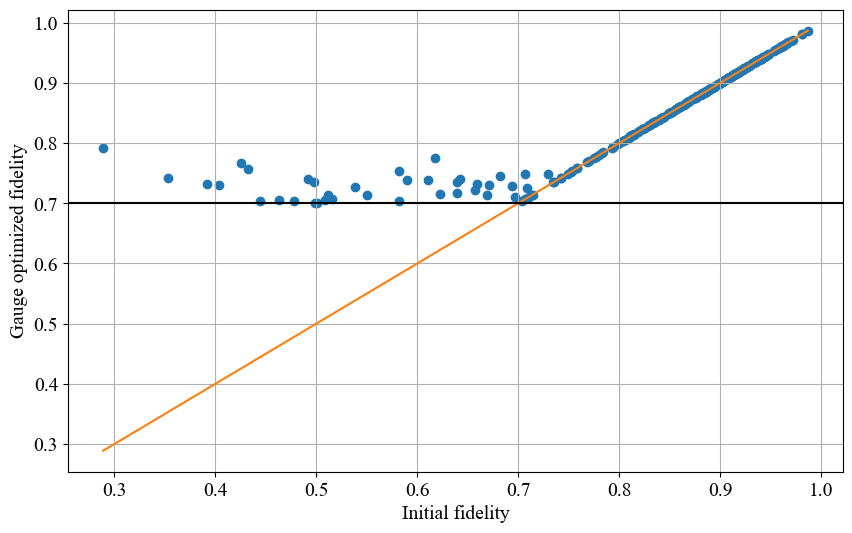

In [4]:
plt.scatter(F_naive,F)
plt.plot([min(F_naive),max(F_naive)],[min(F_naive),max(F_naive)],color = 'C1')
plt.xlabel('Initial fidelity')
plt.ylabel('Gauge optimized fidelity')
plt.grid()
plt.axhline(y=0.7,color='k')

In [11]:
# Convert to PyTorch tensors
X = torch.tensor(P_train, dtype=torch.float32)   # inputs: 3 probabilities
y = torch.tensor(F_train, dtype=torch.float32).unsqueeze(1)  # output: fidelity

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# -----------------------------
# Simple MLP model
# -----------------------------
# model = nn.Sequential(
#     nn.Linear(3, 32),
#     nn.ReLU(),
#     nn.Linear(32, 32),
#     nn.ReLU(),
#     nn.Linear(32, 1)
# )

model = nn.Sequential(
    nn.Linear(3, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(32, 1),
    nn.Sigmoid()
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -----------------------------
# Training loop
# -----------------------------
epochs = 200
for epoch in range(epochs):
    for xb, yb in dataloader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")


Epoch 10, Loss: 0.010393
Epoch 20, Loss: 0.010279
Epoch 30, Loss: 0.009967
Epoch 40, Loss: 0.005806
Epoch 50, Loss: 0.005527
Epoch 60, Loss: 0.006407
Epoch 70, Loss: 0.005348
Epoch 80, Loss: 0.006203
Epoch 90, Loss: 0.006279
Epoch 100, Loss: 0.004742
Epoch 110, Loss: 0.003536
Epoch 120, Loss: 0.003964
Epoch 130, Loss: 0.004460
Epoch 140, Loss: 0.003861
Epoch 150, Loss: 0.004351
Epoch 160, Loss: 0.005576
Epoch 170, Loss: 0.004439
Epoch 180, Loss: 0.003855
Epoch 190, Loss: 0.003925
Epoch 200, Loss: 0.005988


In [12]:
# Test prediction
F_predicted = []
for P in P_test:
    _P_test_tensor = torch.tensor(P).unsqueeze(0)  # Batch dimension (1 sample)
    _prediction = model(_P_test_tensor).detach().numpy().flatten()
    F_predicted.append(_prediction)

C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_8000\1514220721.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([min(F_test), max(F_test)], [min(F_test), max(F_test)], 'r--', color='C1', label='Ideal 1:1 Line')


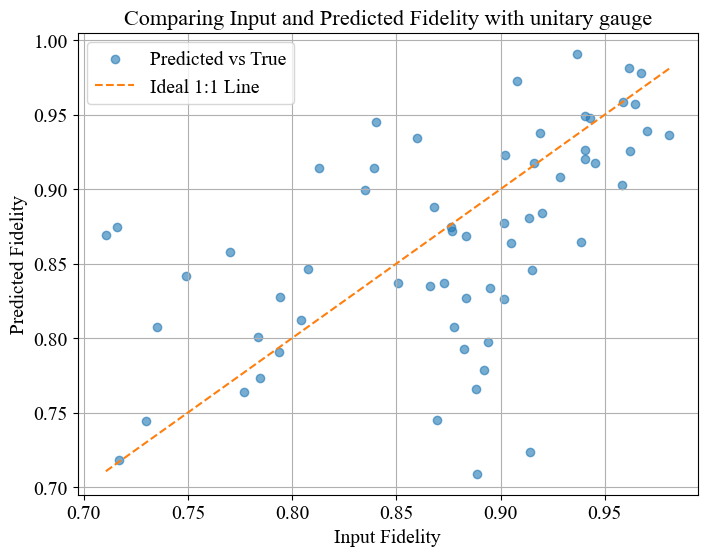

In [13]:
# -----------------------------
# Plot results
# -----------------------------
plt.figure(figsize=(8, 6))

# Scatter plot of true vs predicted fidelities
plt.scatter(F_test, F_predicted, label='Predicted vs True', alpha=0.6)

# Plot ideal 1:1 line (perfect prediction)
plt.plot([min(F_test), max(F_test)], [min(F_test), max(F_test)], 'r--', color='C1', label='Ideal 1:1 Line')

# Labels and title
plt.xlabel("Input Fidelity", fontsize=14)
plt.ylabel("Predicted Fidelity", fontsize=14)
plt.title("Comparing Input and Predicted Fidelity with unitary gauge", fontsize=16)

# Show grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()